# Deep Q-Learning

[https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)  
[https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/P20-AI-AZ-Handbook-Kickstarter.pdf](https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/P20-AI-AZ-Handbook-Kickstarter.pdf)  
[https://web.stanford.edu/class/aa228/reports/2019/final8.pdf](https://web.stanford.edu/class/aa228/reports/2019/final8.pdf)


---
## Markov Decision Process (MDP)

- $A$ : Action space
- $T$ : Transition rule (deterministic most of the time)
$$T : (a_t\in A, s_t \in S, s_t+1\in S) \mapsto \mathbb{P}(s_{t+1}|s_t,a_t)$$
- $R$ : Reward function
$$R : (a_t\in A, s_t \in S) \mapsto r_t \in \mathbb{R}$$


**The probability the state $s_{t+1}$ occurs only depends on state $s_t$ and action $a_t$.**
$$\mathbb{P}(s_{t+1}|s_0,a_0,a_1,s_1,...,s_t,a_t)=\mathbb{P}(s_{t+1}|s_t,a_t)$$ 

### Goal

Approximate the optimal **policy function** $\pi$
$$\pi:s_t\in S\mapsto a_t \in A$$

The optimal policy function can be expressed as follows : 
$$\pi^* = \underset{\pi \in \Pi}{argmax} \sum_{t\geq 0}R(\pi(s_t), s_t)$$

---
## DQN implementation to solve LunarLander-v2
![r](https://pylessons.com/media/Tutorials/Reinforcement-learning-tutorial/LunarLander-v2-PPO/1.png)

- Action space : {1, 2, 3, 4}  
0: Do nothing  
1: left engine  
2: main engine  
3: right engine

- Observation space : Box([-1.5 -1.5 -5. -5. -3.1415927 -5. -0. -0. ], [1.5 1.5 5. 5. 3.1415927 5. 1. 1. ], (8,), float32)

- Rewards:  
  - is increased/decreased the closer/further the lander is to the landing pad.  
  - is increased/decreased the slower/faster the lander is moving.  
  - is decreased the more the lander is tilted (angle not horizontal).  
  - is increased by 10 points for each leg that is in contact with the ground.  
  - is decreased by 0.03 points each frame a side engine is firing.  
  - is decreased by 0.3 points each frame the main engine is firing.  
  
The episode receive an additional reward of -100 or +100 points for crashing or landing safely respectively.  
An episode is considered a solution if it scores at least 200 points.

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
from tqdm import tqdm

import torch as T
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam

T.manual_seed(0)
random.seed(0)
np.random.seed(0)

device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Replay memory

In [2]:
class ReplayMemory:
    """
    Memory used by the agent to sample batches of states in ordr to train the neural network.
    It is implemented as a FIFO. Hence only the max_len ast states can be used for training.
    """
    def __init__(self, max_len, obs_dim, action_dim):        
        self.max_len = max_len
        self.index = 0

        self.state_mem = np.zeros((max_len, *obs_dim), dtype=np.float32)
        self.next_state_mem = np.zeros((max_len, *obs_dim), dtype=np.float32)
        self.reward_mem = np.zeros(max_len, dtype=np.float32)
        self.action_mem = np.zeros(max_len, dtype=np.int16)
        self.terminal_mem = np.zeros(max_len, dtype=bool)

    def __len__(self):
        return self.index

    def push(self, state, action, next_state, reward, is_terminal):
        self.state_mem[self.index] = state
        self.next_state_mem[self.index] = next_state
        self.reward_mem[self.index] = reward
        self.action_mem[self.index] = action
        self.terminal_mem[self.index] = is_terminal

        self.index = (self.index + 1) % self.max_len

    def sample(self, batch_size):
        assert  len(self) >= batch_size

        indices = np.random.choice(len(self), batch_size, replace=False)

        state_batch = T.tensor(self.state_mem[indices])
        next_state_batch = T.tensor(self.next_state_mem[indices])
        reward_batch = T.tensor(self.reward_mem[indices])
        action_batch = self.action_mem[indices]
        terminal_batch = T.tensor(self.terminal_mem[indices])

        return state_batch, action_batch, next_state_batch, reward_batch, terminal_batch

### Define the Deep neural network

![ill](./res/nn.svg)

In [3]:
class DQN(nn.Module):
    """
    Implements a simple 2-layers MLP with MSE loss and Adam optimizer
    """
    def __init__(self, obs_dim, actions_dim, d_fc1, d_fc2, lr):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(*obs_dim, d_fc1)
        self.fc2 = nn.Linear(d_fc1,d_fc2)
        self.out = nn.Linear(d_fc2,actions_dim)
        self.lr = lr

        self.criterion = nn.MSELoss()
        self.optimizer = Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

### Define the agent to train

In [4]:
class Agent:

    def __init__(self, obs_dim, actions_dim, eps_start, eps_end, eps_decay, gamma, replay_size, batch_size, lr):
        self.eps = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.gamma = gamma
        self.actions_dim = actions_dim

        self.q_func = DQN(obs_dim, actions_dim, d_fc1=128, d_fc2=128, lr=lr)
        # self.target_q_func = DQN(obs_dim, actions_dim, d_fc1=128, d_fc2=128, lr=lr)
        # self.target_q_func.load_state_dict(self.q_func.state_dict())
        self.possible_actions = np.arange(actions_dim)

        self.lr = lr
        self.batch_size = batch_size
        self.replay_size = replay_size
        self.replay_mem = ReplayMemory(replay_size, obs_dim, actions_dim)

    def choose_action(self, state):
        if np.random.random() > self.eps:
            state = T.tensor(state, device=device)
            actions = self.q_func(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.possible_actions)
        return action

    def train(self):
        if len(self.replay_mem) < self.batch_size:
            return

        self.q_func.optimizer.zero_grad()

        state_batch, action_batch, next_state_batch, reward_batch, terminal_batch = self.replay_mem.sample(self.batch_size)
        state_batch = state_batch.to(device)
        next_state_batch = next_state_batch.to(device)

        batch_indices = np.arange(self.batch_size, dtype=np.int32)
        q_values = self.q_func(state_batch)[batch_indices, action_batch] # Only keep q-values corresponding to the action
        q_next = self.q_func(next_state_batch)
        # q_next = self.target_q_func(next_state_batch)
        q_next[terminal_batch] = 0.

        q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]

        loss = self.q_func.criterion(q_target, q_values).to(device)
        loss.backward()
        self.q_func.optimizer.step()

        self.eps = self.eps_decay * self.eps if self.eps > self.eps_end else self.eps_end
        # self.copy_policy_to_target_state_dict()

    def copy_policy_to_target_state_dict(self, tau=0.005):
        q_func_state_dict = self.q_func.state_dict()
        target_q_func_state_dict = self.target_q_func.state_dict()
        for key in q_func_state_dict:
            target_q_func_state_dict[key] = q_func_state_dict[key]*tau + target_q_func_state_dict[key]*(1-tau)
        self.target_q_func.load_state_dict(target_q_func_state_dict)

### Training the network

The traning process is unstable, as rewards earned from one epoch to another can be highly different.

In [5]:
env = gym.make('LunarLander-v2')
n_episodes = 300
scores = []
scores_window = deque(maxlen=70)
avg_scores = []
losses = []
epsilons = []

agent = Agent(obs_dim=[8], actions_dim=4, eps_start=1.0, eps_end=0.01, eps_decay=0.996, gamma=0.99, replay_size=100_000, batch_size=64, lr=0.0005)

for ep in tqdm(range(n_episodes)):
    state, _ = env.reset()
    done = False
    score = 0.0
    while not done:
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.replay_mem.push(state, action, next_state, reward, done)
        agent.train()
        state = next_state
        score += reward
    # agent.copy_policy_to_target_state_dict()
    scores.append(score)
    scores_window.append(score)
    avg_scores.append(np.mean(scores_window))
    epsilons.append(agent.eps)

100%|██████████| 300/300 [15:02<00:00,  3.01s/it]


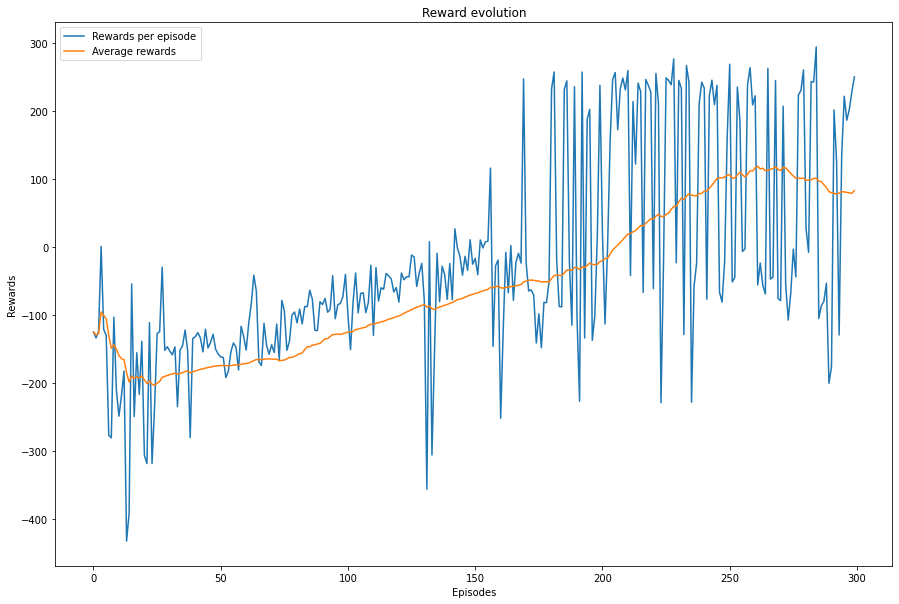

In [6]:
plt.figure(figsize=(15,10))
plt.title('Reward evolution')
plt.plot(scores, label='Rewards per episode')
plt.plot(avg_scores, label='Average rewards')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()

### Testing the trained model

In [9]:
def test_env(n_ticks=10_000):
    env_t = gym.make('LunarLander-v2', render_mode='human')
    state, _ = env_t.reset()
    done = False

    for _ in range(n_ticks):
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, _ = env_t.step(action)
        done = terminated or truncated
        if done:
            state, _ = env_t.reset()
        else:
            state = next_state
    

test_env()